# Install dependencies and load the dataset

In [1]:
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/penguins.csv')

print(data.head())

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE


# Quick EDA

Check for missing values

In [3]:
data.isnull().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Check penguins sex for latter numericalization

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

Handle `NaN`

In [5]:
data['sex'] = data['sex'].replace('.', np.nan)
data = data.dropna(subset=['sex'])
data = data.reset_index(drop=True)


Encode `MALE` and `FEMALE`

In [6]:
data['sex'] = data['sex'].str.upper()
data['sex'] = data['sex'].map({'MALE': 1, 'FEMALE': 0})

data['sex'].head()


0    1
1    0
2    0
3    0
4    1
Name: sex, dtype: int64

Control dtype of other columns

In [7]:
feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
data[feature_cols] = data[feature_cols].astype(float)

Standardize the features to have zero mean and unit variance - crucial preprocessing step especially when dealing with features that have different units or scales in order to enhance the fairness and effectiveness of the algorithm by allowing it to consider all features equally

In [8]:
from sklearn.preprocessing import StandardScaler

X = data[feature_cols]
y = data['sex']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split and train

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42)


Load the model

In [10]:
import sys
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.join(notebook_dir, '..'))
from src import KNNClassifier

In [11]:
K = 3
knn = KNNClassifier(K=K)
knn.fit(X_train, y_train)


In [12]:
predictions = knn.predict(X_test)

## Result and Evaluation

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"\nKNN Classification Accuracy: {accuracy * 100:.2f}%")



KNN Classification Accuracy: 88.06%


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=['FEMALE', 'MALE']))

              precision    recall  f1-score   support

      FEMALE       0.97      0.91      0.94        33
        MALE       0.92      0.97      0.94        34

    accuracy                           0.94        67
   macro avg       0.94      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



In [15]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[29  4]
 [ 4 30]]


## Visualization

For this dataset, it is better to use PCA first, reduce to 2 PC for better visualization

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


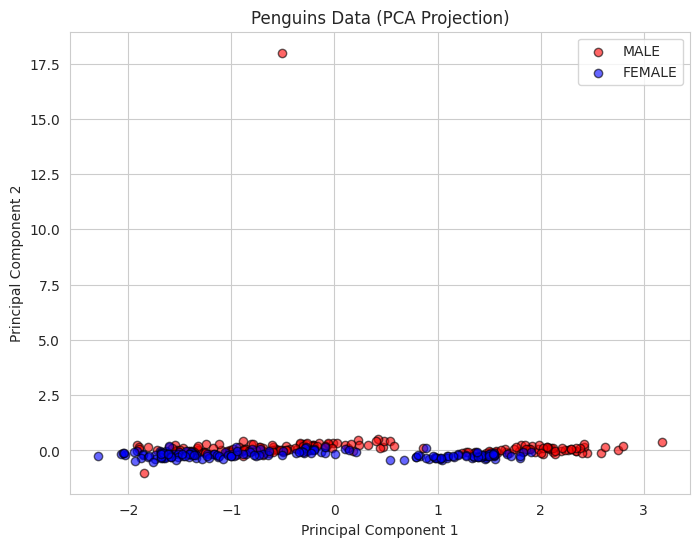

In [23]:
pca_df = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'Sex': y})

plt.figure(figsize=(8, 6))
colors = {0: 'blue', 1: 'red'}
labels = {0: 'FEMALE', 1: 'MALE'}

for sex in pca_df['Sex'].unique():
    subset = pca_df[pca_df['Sex'] == sex]
    plt.scatter(subset['PC1'], subset['PC2'], c=colors[sex], label=labels[sex], alpha=0.6, edgecolor='k')

plt.title('Penguins Data (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Optimize K

Cross validate to find the best value of $K$

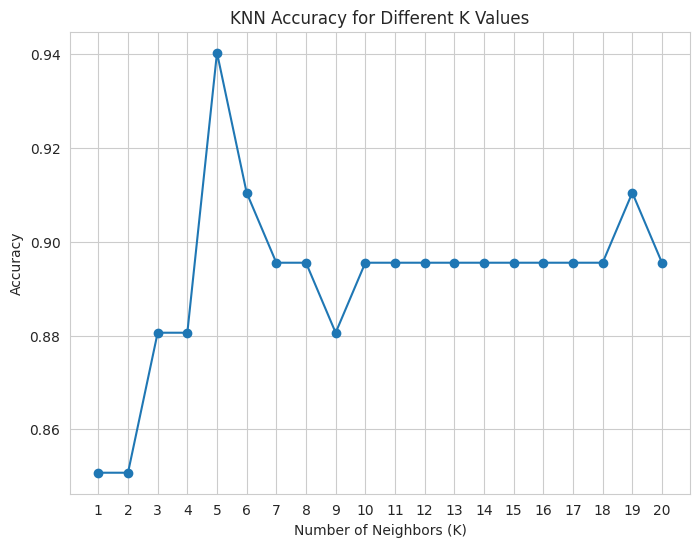


Optimal K: 5


In [24]:
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNNClassifier(K=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracy_scores.append(acc)

plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('KNN Accuracy for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Find the optimal K
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f"\nOptimal K: {optimal_k}")


Let's retrain using $K = 5$

In [25]:
knn = KNNClassifier(K=optimal_k)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"\nKNN Classification Accuracy with K={optimal_k}: {accuracy * 100:.2f}%")


KNN Classification Accuracy with K=5: 94.03%
